In [1]:
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [2]:
try :
    %tensorflow_version 2.x
except :
    pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import gensim.models
import nltk

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences 

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_clickbait = pd.read_csv ('/content/drive/My Drive/clickbait_data' , sep = '\n' , header = None)
data_noclickbait = pd.read_csv ('/content/drive/My Drive/non_clickbait_data' , sep = '\n' , header = None)
data_clickbait['class'] = [1 for i in range(data_clickbait.shape[0])]
data_noclickbait['class'] = [0 for i in range(data_noclickbait.shape[0])] 
data_Final = pd.concat((data_clickbait , data_noclickbait), ignore_index = True) 
df = data_Final.rename(columns = { 0 : "text" })
print(df.shape)
df.head(5)

(32000, 2)


,text,class
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


In [6]:
stop_words  = set(stopwords.words('english'))

In [7]:
L = []
for  i , token  in  enumerate (df['text']) :
    words = [w for w in token.split()]
    L.append(len(words))
sequence_size = max (L)

X = df['text']
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [8]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [9]:
WORD2VEC_VECTORS_BIN  = '/content/drive/My Drive/GoogleNews-vectors-negative300.bin'
w2v  =  gensim.models.KeyedVectors.load_word2vec_format(WORD2VEC_VECTORS_BIN , binary = True)

In [10]:
embedding_dim = 300
def create_data(data, sequence_size, embedding_dim):
    embedding_data = np.zeros((len(data), sequence_size, embedding_dim))
    for i,sentence in enumerate(data) :
        sentence = sentence.replace('-', ' ')
        words = nltk.word_tokenize(sentence)
        j = 0 
        for w in words:
            try :
                embedding_data[i , j] = w2v[w]
                j += 1
            except :
                pass
    return embedding_data
        
train_data = create_data(X_train, sequence_size, embedding_dim)
test_data = create_data(X_test, sequence_size, embedding_dim)
val_data = create_data(X_val, sequence_size, embedding_dim)
print(test_data.shape)
print(train_data.shape)
print(val_data.shape)

(6400, 26, 300)
(19200, 26, 300)
(6400, 26, 300)


In [11]:
class PositionalEncoding(layers.Layer):
  
    def __init__(self) :
        super(PositionalEncoding, self).__init__()
    def get_angles(self, pos, i, d_model) :
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles

    def call(self, inputs) :
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        pos_encoding = angles[np.newaxis, ...]
        return inputs + tf.cast(pos_encoding, tf.float32)

In [12]:
def scaled_dot_product_attention(queries, keys, values, mask) :
    product = tf.matmul(queries, keys, transpose_b  = True)
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    scaled_product = product / tf.math.sqrt(keys_dim)
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis = -1), values)
    return attention

In [13]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, nb_proj) :
        super(MultiHeadAttention, self).__init__()
        self.nb_proj = nb_proj
        
    def build(self, input_shape) :
        self.d_model = input_shape[-1]
        assert self.d_model % self.nb_proj == 0
        self.d_proj = self.d_model // self.nb_proj
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): 
        shape = (batch_size,-1, self.nb_proj,self.d_proj)
        splited_inputs = tf.reshape(inputs, shape=shape)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) 
    
    def call(self, queries, keys, values, mask) :
        batch_size = tf.shape(queries)[0]
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention,shape=(batch_size, -1, self.d_model))
        outputs = self.final_lin(concat_attention)
        return outputs

In [14]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, nb_proj, dropout_rate) :
        super(EncoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape) :
        self.d_model = input_shape[-1]
        self.multi_head_attention = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.dense_1 = layers.Dense(units=self.FFN_units, activation="relu")
        self.dense_2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training) :
        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        attention = self.norm_1(attention + inputs)
        outputs = self.dense_1(attention)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        outputs = self.norm_2(outputs + attention)
        return outputs

In [15]:
class Encoder(layers.Layer) :
    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 d_model,
                 name="encoder") :

        super(Encoder, self).__init__(name=name)
        self.nb_layers = nb_layers
        self.d_model = d_model
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.enc_layers = [EncoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate) 
                           for _ in range(nb_layers)]
    
    def call(self, inputs, mask, training) :
        inputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(inputs)
        outputs = self.dropout(outputs, training)
        for i in range(self.nb_layers) :
            outputs = self.enc_layers[i](outputs, mask, training)
        return outputs

In [16]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 d_model,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        
        self.encoder = Encoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               d_model)
    
    def create_padding_mask(self, seq):
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, training = True):
        enc_mask = self.create_padding_mask(enc_inputs)
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        return enc_outputs

In [18]:
D_MODEL = 300
NB_LAYERS = 2
FFN_UNITS = 512
NB_PROJ = 4
DROPOUT_RATE = 0.1
transformer = Transformer(d_model = D_MODEL,
                          nb_layers = NB_LAYERS,
                          FFN_units = FFN_UNITS,
                          nb_proj = NB_PROJ,
                          dropout_rate = DROPOUT_RATE)


  
inputs = layers.Input(shape = (sequence_size,D_MODEL))
x = transformer(inputs)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(DROPOUT_RATE)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs = inputs, outputs = outputs)
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 300)]         0         
_________________________________________________________________
transformer (Transformer)    (None, 26, 300)           1340824   
_________________________________________________________________
flatten (Flatten)            (None, 7800)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3994112   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [19]:
history = model.fit(train_data, y_train, batch_size = 64, epochs = 20, validation_data = (val_data , y_val), verbose = 1)

Epoch 1/20
300/300 [==============================] - 10s 32ms/step - loss: 0.1624 - accuracy: 0.9571 - val_loss: 0.1042 - val_accuracy: 0.9744
Epoch 2/20
300/300 [==============================] - 9s 29ms/step - loss: 0.0544 - accuracy: 0.9823 - val_loss: 0.0698 - val_accuracy: 0.9831
Epoch 3/20
300/300 [==============================] - 9s 29ms/step - loss: 0.0459 - accuracy: 0.9859 - val_loss: 0.0580 - val_accuracy: 0.9844
Epoch 4/20
300/300 [==============================] - 9s 29ms/step - loss: 0.0402 - accuracy: 0.9867 - val_loss: 0.0475 - val_accuracy: 0.9814
Epoch 5/20
300/300 [==============================] - 9s 29ms/step - loss: 0.0336 - accuracy: 0.9879 - val_loss: 0.0652 - val_accuracy: 0.9825
Epoch 6/20
300/300 [==============================] - 9s 29ms/step - loss: 0.0401 - accuracy: 0.9879 - val_loss: 0.0742 - val_accuracy: 0.9772
Epoch 7/20
300/300 [==============================] - 9s 29ms/step - loss: 0.0380 - accuracy: 0.9879 - val_loss: 0.0462 - val_accuracy: 0.983

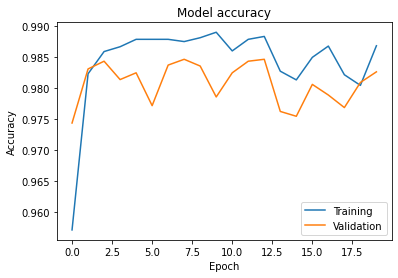

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

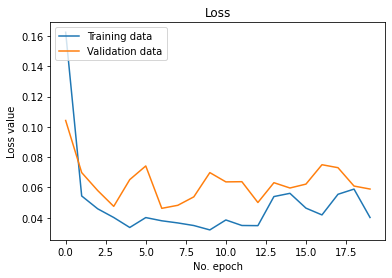

In [21]:
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [22]:
y_pred = model.predict(test_data)

In [23]:
y_pred

array([[2.0939126e-08],
       [2.3471547e-07],
       [9.9992108e-01],
       ...,
       [9.9971157e-01],
       [9.9863094e-01],
       [8.8735662e-02]], dtype=float32)

In [24]:
score , acc  =  model.evaluate(test_data, y_test, batch_size = 64)

100/100 [==============================] - 1s 9ms/step - loss: 0.0578 - accuracy: 0.9822


In [25]:
print('Test Score:', score)

 Test Score :  0.057759568095207214


In [26]:
print('Test Accuracy : ', acc)

Test Accuracy :  0.9821875095367432


In [27]:
def predict_function(y_pred) :
    for i in range(y_pred.shape[0]) :
        if y_pred[i][0] >= 0.5 :
            y_pred[i][0] = 1
        else :
            y_pred[i][0] = 0
        return y_pred.astype('int64')

In [28]:
y_pred = predict_function(y_pred)

In [29]:
y_test = y_test.reshape(-1,1)

In [30]:
metrics = classification_report(y_test, y_pred, digits = 4)

print('Classification Report ')
print("\n")
print(metrics)
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix')
print("\n")
print(cm)

Classification Report 


              precision    recall  f1-score   support

           0     0.9868    0.9767    0.9817      3127
           1     0.9779    0.9875    0.9827      3273

    accuracy                         0.9822      6400
   macro avg     0.9823    0.9821    0.9822      6400
weighted avg     0.9822    0.9822    0.9822      6400

Confusion Matrix


[[3054   73]
 [  41 3232]]


In [31]:
def TestingOwnData(sentence) :
    X = np.zeros((1,sequence_size,300))
    sentence = sentence.replace('-',' ')
    words = nltk.word_tokenize(sentence)
    j = 0
    for w in words:
        try :
            X[0,j] = w2v[w]
            j += 1
        except :
            pass
    prediction = predict_function(model.predict(X))[0][0]
    if prediction == 1 :         
        return 'Clickbait'
    return 'Not A Clickbait'

In [32]:
TestingOwnData('Amazing Inventions You Won’t Believe Exist')

'Clickbait'

In [33]:
TestingOwnData('Tamil Nadu reports 4,280 fresh COVID-19 cases and 65 deaths')

'Not A Clickbait'

In [34]:
TestingOwnData('Can Face Masks Prevent You From Getting the Coronavirus? Doctors Weight In')

'Clickbait'

In [35]:
TestingOwnData('PM Modi asks to prepare Digital booklets documenting the relief works')

'Not A Clickbait'

In [36]:
TestingOwnData('No passenger flights to Kolkata from Delhi, Mumbai, Chennai and 3 other cities between Jul 6-19')

'Not A Clickbait'